**Some useful modules**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import DataFrame
from pandas import concat
from pandas.plotting import autocorrelation_plot
from numpy import array
from numpy import argmax;
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import pandas as pd
%matplotlib inline
import scipy.special 
import random
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from datetime import datetime
import seaborn as sn
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
airline_data= pd.read_csv("/content/drive/MyDrive/Airline.csv")

**Explanatory Data Analysis**

In [ ]:
print(airline_data.head(15))
print(airline_data.shape)
print(airline_data.columns)

       Date  Passengers
0   1949-01         112
1   1949-02         118
2   1949-03         132
3   1949-04         129
4   1949-05         121
5   1949-06         135
6   1949-07         148
7   1949-08         148
8   1949-09         136
9   1949-10         119
10  1949-11         104
11  1949-12         118
12  1950-01         115
13  1950-02         126
14  1950-03         141
(144, 2)
Index(['Date', 'Passengers'], dtype='object')


Original data has two features

1.   Date
2.   Passengers

Features have 144 samples. (monthly data --> 144 months = 12 years



In [ ]:
# Checking missing values
bool_series = pd.isnull(airline_data["Passengers"])
print(airline_data[bool_series])

,Date,Passengers


Since this is empty, there is no missing value in data.

In [ ]:
airline_data.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [ ]:
# Take Date feature as datetime index for simplicity
airline_data['Date'] = pd.to_datetime(airline_data['Date'], infer_datetime_format=True)
indexed_data = airline_data.set_index(['Date']) # 144 rows  x 1 columns
print(indexed_data)

            Passengers
Date                  
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]


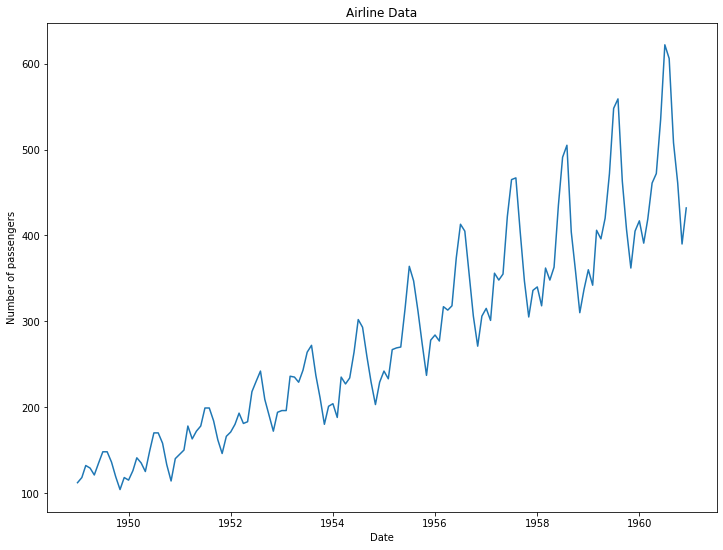

In [ ]:
plt.rcParams["figure.figsize"] = (12,9)
plt.xlabel("Date")
plt.ylabel("Number of passengers")
plt.title("Airline Data")
plt.plot(indexed_data)

As can be seen above, data seasonal (number of passengers has similar behaviour in same month, different years) it has a increasing trend every year.

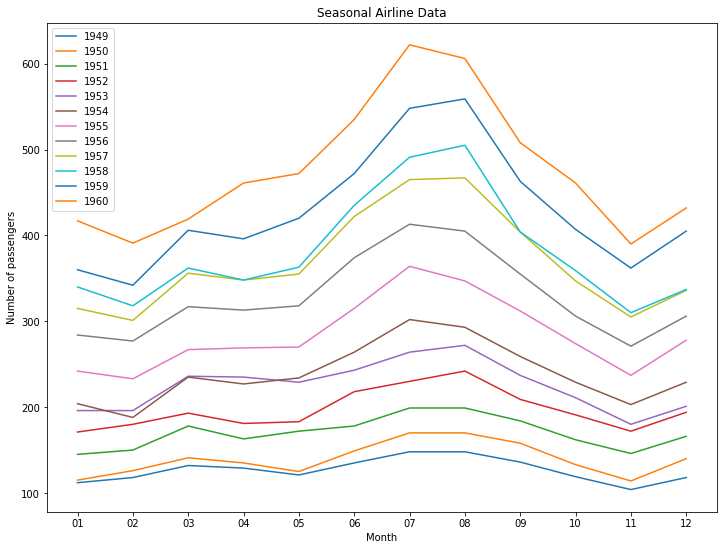

In [ ]:
month=[]
year=[]
for i in range(144):
  #airline_data["Date"][i] = datetime.now() 
  month.append(airline_data["Date"][i].strftime("%m"))
  year.append(airline_data["Date"][i].strftime("%Y"))
index_numbers= list(range(0,144,12))
starting_year = 1949
fig, ax = plt.subplots()
for i in index_numbers:
  ax.plot(month[0:12],airline_data["Passengers"][i:i+12], label= starting_year)
  starting_year += 1
plt.xlabel("Month")
plt.ylabel("Number of passengers")
plt.title("Seasonal Airline Data")
leg = ax.legend()


Now it seems clearer above, airline data has seasonal feature.

Notes:

*   Some values break seasonality and trend. For more accuracy, these values can change in future (ex. 1954-February)




**Box Plot**

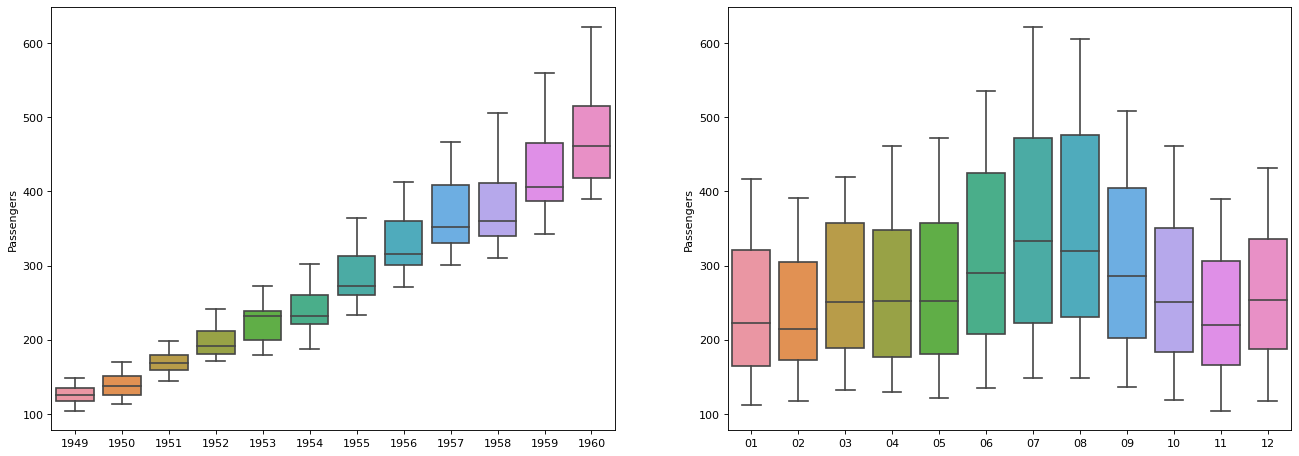

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x=year, y=airline_data["Passengers"],  ax= axes[0])
sns.boxplot(x=month, y=airline_data["Passengers"], ax= axes[1])

The boxplots make the year-wise and month-wise distributions evident. 

**Density Plot**

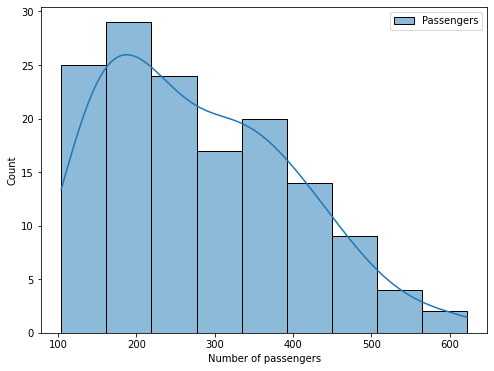

In [ ]:
plt.figure(figsize = (8,6))
sns.histplot(airline_data, kde = True)
plt.xlabel('Number of passengers')
plt.ylabel('Count')
plt.show()

**Autoregression plots**

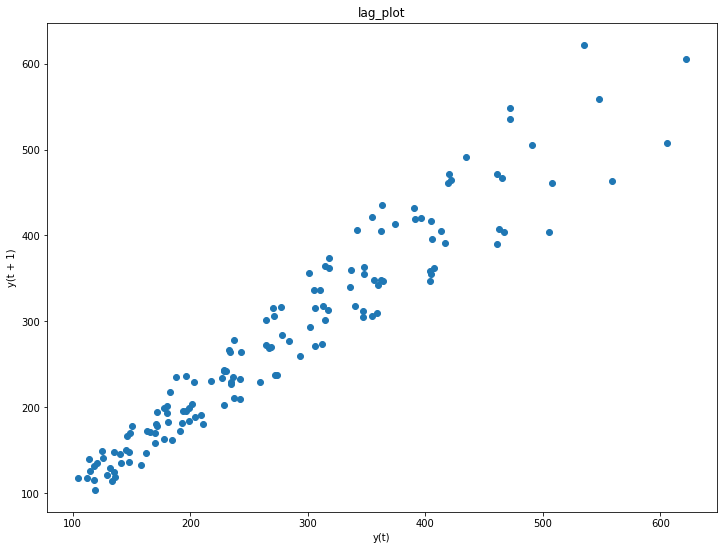

In [ ]:
lag_plot(indexed_data)
plt.title("lag_plot")
plt.show()

Correlation between lagged values and original values can be visualized easily above. There is strong positive correlation. This can be check numerically as below

In [ ]:
values = DataFrame(indexed_data.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.960195
t+1  0.960195  1.000000


Strong positive correlation (0.960195) between the original values and lag=1 value. 

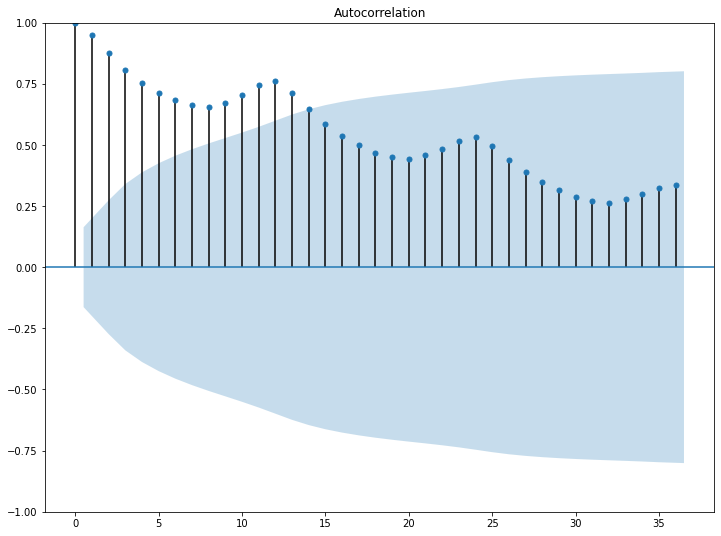

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(indexed_data, lags=36)
plt.show()

In the above plot, the blue region is the confidence band and autocorrelation up to lag 13 lies outside this blue region. This means that values up to lag 13 are statistically significant, that is, they affect the current price.

**End of the autoregression plots**

<Figure size 1296x576 with 0 Axes>

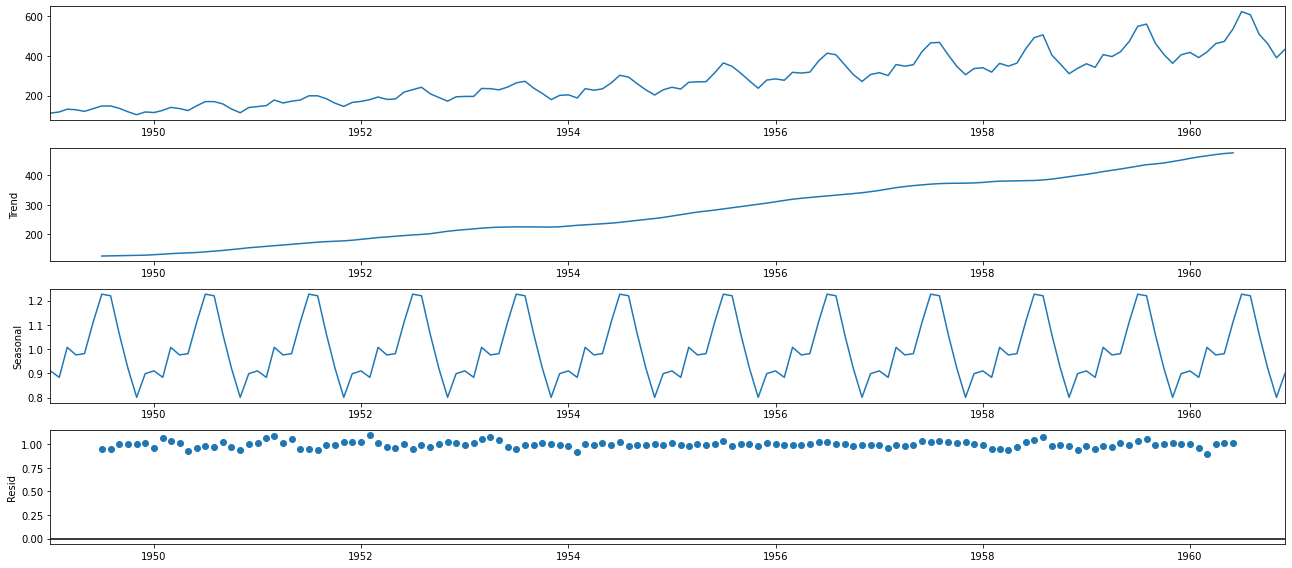

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(indexed_data, model = 'multiplicative')
plt.figure(figsize = (18,8))
decomposition.plot()
plt.show()

**Stationary Check**

Time Series is said to be stationary when the time series data has constant mean & variance over time. Forecasting a stationary series is relatively easy and the forecasts are more reliable. Therefore, if data non-stationary, making it a stationary will make forecasting easier.

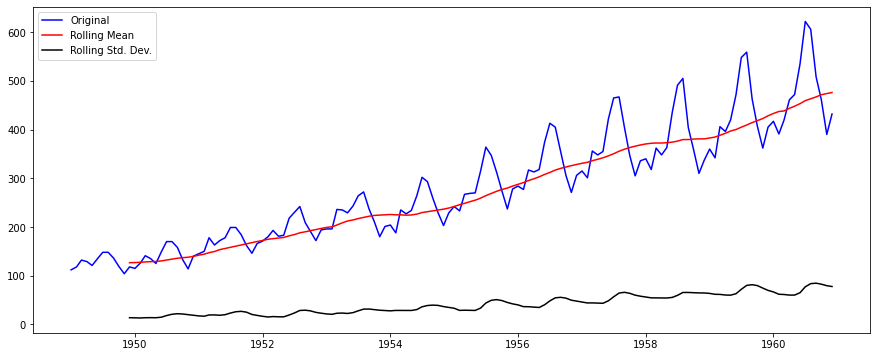

In [ ]:
# Rolling Mean & Rolling Standard Deviation
rolmean = indexed_data.rolling(window = 12).mean()
rolstd = indexed_data.rolling(window = 12).std()

plt.figure(figsize = (15,6))
orig = plt.plot(indexed_data, color = 'blue', label ='Original')
mean  = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rolstd, color = 'black', label = 'Rolling Std. Dev.')
plt.legend(loc = 'best')
plt.show()

Since rolling mean and rolling std. dev are not constant, data is non-station. Also it can be check numerically by using Augmented Dicky-Fuller Test.

In [ ]:
print('-------------Results of Dicky Fuller Test -------------')
dftest = adfuller(airline_data['Passengers'], autolag = 'AIC')
dfoutput = pd.Series(data = dftest[0:4], index = ['Test Statistic : adf', 'p-value : MacKinnon\'s approximate p-value',
                                                 'No. of Lags used', 'No. of observations used'])
for key,value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
dfoutput['Maximized AIC:'] = dftest[5]
print(dfoutput)

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                           0.815369
p-value : MacKinnon's approximate p-value      0.991880
No. of Lags used                              13.000000
No. of observations used                     130.000000
Critical Value (1%)                           -3.481682
Critical Value (5%)                           -2.884042
Critical Value (10%)                          -2.578770
Maximized AIC:                               996.692931
dtype: float64


Critical number for Augmented Dicky-Fuller Test (p-value) = 0.05. Since p-value more than 0.05, this data is non-stationary

In [ ]:
# Creating general function to test stationarity of a time series

def test_stationarity(timeseries):
    # Rolling Mean & Rolling Standard Deviation
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()

    plt.figure(figsize = (15,6))
    orig = plt.plot(timeseries, color = 'blue', label ='Original')
    mean  = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std. Dev.')
    plt.legend(loc = 'best')
    plt.show()
    
    # Augmented Dicky-Fuller Test
    print('-------------Results of Dicky Fuller Test -------------')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(data = dftest[0:4], index = ['Test Statistic : adf', 'p-value : MacKinnon\'s approximate p-value',
                                                     'No. of Lags used', 'No. of observations used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    dfoutput['Maximized AIC:'] = dftest[5]
    print(dfoutput)

**Making stationary**

Text(0.5, 1.0, 'Log-scaled airline data')

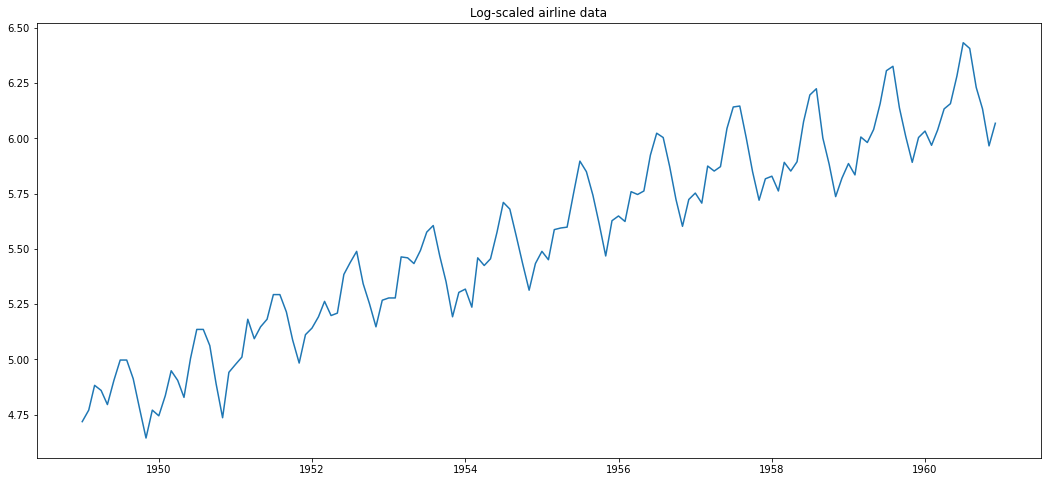

In [ ]:
# Log Transformation
log_scaled = np.log(indexed_data)
plt.plot(log_scaled)
plt.title("Log-scaled airline data")

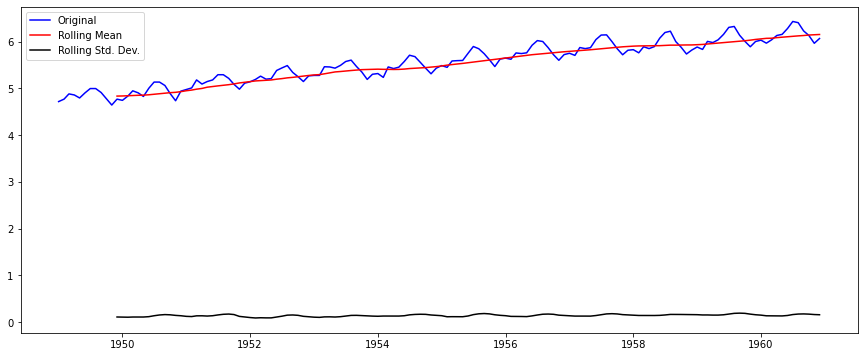

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                          -1.717017
p-value : MacKinnon's approximate p-value      0.422367
No. of Lags used                              13.000000
No. of observations used                     130.000000
Critical Value (1%)                           -3.481682
Critical Value (5%)                           -2.884042
Critical Value (10%)                          -2.578770
Maximized AIC:                              -445.399031
dtype: float64


In [ ]:
# Stationarity check for log-scaled data
test_stationarity(log_scaled["Passengers"])

Since the p-value is still below 0.05, data is non-station.

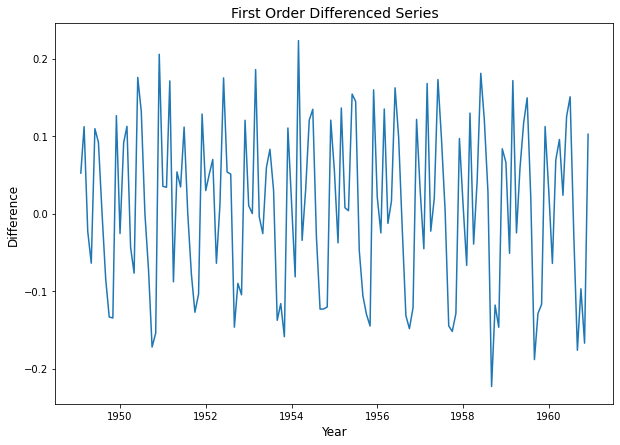

In [ ]:
log_scaled['Passengers'] = log_scaled['Passengers'].diff()

# Plot the Change
plt.figure(figsize=(10, 7))
plt.plot(log_scaled['Passengers'])
plt.title('First Order Differenced Series', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.show()

In [ ]:
# dropping NAN values from log_scaled
new_log_scaled= log_scaled.dropna()
new_log_scaled

,Passengers
Date,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


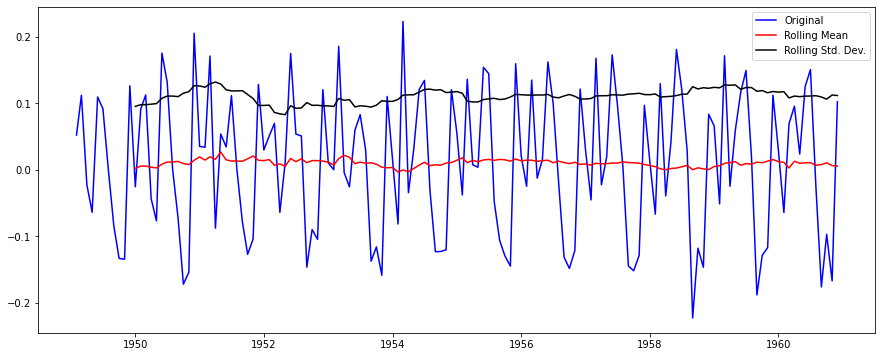

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                          -2.717131
p-value : MacKinnon's approximate p-value      0.071121
No. of Lags used                              14.000000
No. of observations used                     128.000000
Critical Value (1%)                           -3.482501
Critical Value (5%)                           -2.884398
Critical Value (10%)                          -2.578960
Maximized AIC:                              -440.358470
dtype: float64


In [ ]:
# first differencing stationarity test
test_stationarity(new_log_scaled["Passengers"])

Now, data is almost station. 0.07 ~ 0.05

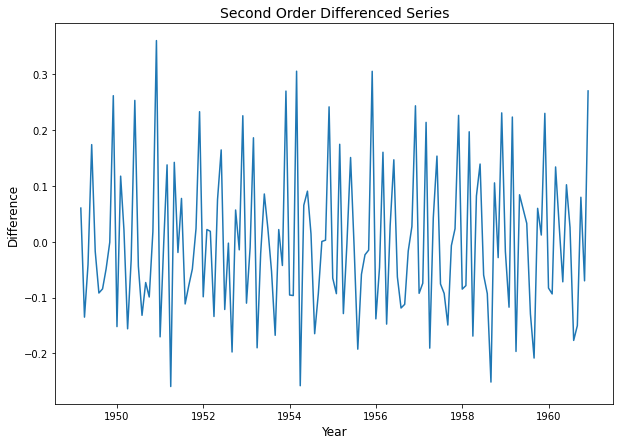

In [ ]:
# second differencing
new_log_scaled['Passengers'] = new_log_scaled['Passengers'].diff()

# Plot the Change
plt.figure(figsize=(10, 7))
plt.plot(new_log_scaled['Passengers'])
plt.title('Second Order Differenced Series', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.show()

# dropping NAN values from new_log_scaled
stationary_data= new_log_scaled.dropna()

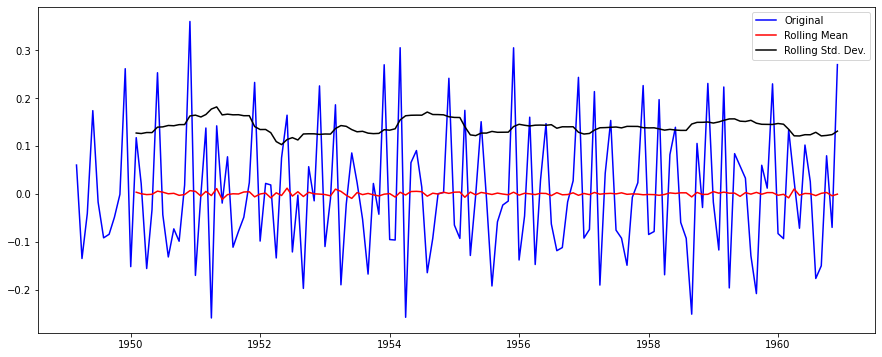

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                        -8.196629e+00
p-value : MacKinnon's approximate p-value    7.419305e-13
No. of Lags used                             1.300000e+01
No. of observations used                     1.280000e+02
Critical Value (1%)                         -3.482501e+00
Critical Value (5%)                         -2.884398e+00
Critical Value (10%)                        -2.578960e+00
Maximized AIC:                              -4.308936e+02
dtype: float64


In [ ]:
# second differencing stationarity test
test_stationarity(stationary_data["Passengers"])

**End of stationarity process**

**Feature Engineering**

In [ ]:
df= indexed_data
df.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
#adding datetime feature
df['month_index']= df.index.month
df["year_index"]= df.index.year
df.head(-10)

,Passengers,month_index,year_index
Date,,,
1949-01-01,112,1,1949
1949-02-01,118,2,1949
1949-03-01,132,3,1949
1949-04-01,129,4,1949
1949-05-01,121,5,1949
...,...,...,...
1959-10-01,407,10,1959
1959-11-01,362,11,1959
1959-12-01,405,12,1959


**Encoding Cyclical Features**

In [ ]:
df['Month_sin'] = np.sin(2 * np.pi * df['month_index']/12.0)
df['Month_cos'] = np.cos(2 * np.pi * df["month_index"]/12.0)
df.head(-5)

,Passengers,month_index,year_index,Month_sin,Month_cos
Date,,,,,
1949-01-01,112,1,1949,5.000000e-01,8.660254e-01
1949-02-01,118,2,1949,8.660254e-01,5.000000e-01
1949-03-01,132,3,1949,1.000000e+00,6.123234e-17
1949-04-01,129,4,1949,8.660254e-01,-5.000000e-01
1949-05-01,121,5,1949,5.000000e-01,-8.660254e-01
...,...,...,...,...,...
1960-03-01,419,3,1960,1.000000e+00,6.123234e-17
1960-04-01,461,4,1960,8.660254e-01,-5.000000e-01
1960-05-01,472,5,1960,5.000000e-01,-8.660254e-01


**One-hot encoding**

In [ ]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import category_encoders as ce

In [ ]:
encoder=ce.OneHotEncoder(cols='month_index',handle_unknown='return_nan',return_df=True,use_cat_names=True)
df = encoder.fit_transform(df)

In [ ]:
df.head()

,Passengers,month_index_1.0,month_index_2.0,month_index_3.0,month_index_4.0,month_index_5.0,month_index_6.0,month_index_7.0,month_index_8.0,month_index_9.0,month_index_10.0,month_index_11.0,month_index_12.0,year_index,Month_sin,Month_cos
Date,,,,,,,,,,,,,,,,
1949-01-01,112,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1949,0.500000,8.660254e-01
1949-02-01,118,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1949,0.866025,5.000000e-01
1949-03-01,132,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1949,1.000000,6.123234e-17
1949-04-01,129,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1949,0.866025,-5.000000e-01
1949-05-01,121,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1949,0.500000,-8.660254e-01


**Lag Features**

In [ ]:
df["Lag1"] = df['Passengers'].shift(1)
df["Lag2"] = df['Passengers'].shift(2)
df["Lag3"] = df['Passengers'].shift(3)
df["Lag4"] = df['Passengers'].shift(4)
df["Lag5"] = df['Passengers'].shift(5)
df["Lag6"] = df['Passengers'].shift(6)
df["Lag7"] = df['Passengers'].shift(7)
df["Lag8"] = df['Passengers'].shift(8)
df["Lag9"] = df['Passengers'].shift(9)
df["Lag10"] = df['Passengers'].shift(10)
df["Lag11"] = df['Passengers'].shift(11)
df["Lag12"] = df['Passengers'].shift(12)

In [ ]:
df['rollingMean12'] = df["Passengers"].rolling(window=12).mean().shift(1)
df['rollingMin12'] = df["Passengers"].rolling(window=12).min().shift(1)
df['rollingMax12'] = df["Passengers"].rolling(window=12).max().shift(1)
df['rollingStd12'] = df["Passengers"].rolling(window=12).std().shift(1)
df['rollingMin2'] = df["Passengers"].rolling(window=2).min().shift(1)
df['rollingMean2'] = df["Passengers"].rolling(window=2).mean().shift(1)
df['rollingMean6'] = df["Passengers"].rolling(window=6).mean().shift(1)
df['rollingMin6'] = df["Passengers"].rolling(window=6).min().shift(1)

df['ExpandingMean'] = df['Passengers'].expanding(12).mean().shift(1)
df['ExpandingMax'] = df['Passengers'].expanding(12).max().shift(1)
df['ExpandingStd'] = df['Passengers'].expanding(12).std().shift(1)
df["ExpandingMin"] = df['Passengers'].expanding(12).min().shift(1)

**Transformation features**

In [ ]:
#df["log"] = np.log(df["Passengers"])
#df["differenced_log"] = df["log"].diff()
#df["scnd_differenced_log"] = df['differenced_log'].diff()

In [ ]:
df= df.dropna()

In [ ]:
df.shape

(132, 40)

In [ ]:
df.head()

,Passengers,month_index_1.0,month_index_2.0,month_index_3.0,month_index_4.0,month_index_5.0,month_index_6.0,month_index_7.0,month_index_8.0,month_index_9.0,...,ExpandingMax,ExpandingStd,ExpandingMin,rollingMin12,rollingMax12,rollingStd12,rollingMin2,rollingMean2,rollingMean6,rollingMin6
Date,,,,,,,,,,,,,,,,,,,,,
1950-01-01,115,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,148.0,13.720147,104.0,104.0,148.0,13.720147,104.0,111.0,128.833333,104.0
1950-02-01,126,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,148.0,13.528697,104.0,104.0,148.0,13.453342,115.0,116.5,123.333333,104.0
1950-03-01,141,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,148.0,12.998098,104.0,104.0,148.0,13.166475,115.0,120.5,119.666667,104.0
1950-04-01,135,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,148.0,13.126854,104.0,104.0,148.0,13.686977,126.0,133.5,120.500000,104.0
1950-05-01,125,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,148.0,12.846368,104.0,104.0,148.0,13.822467,135.0,138.0,123.166667,104.0


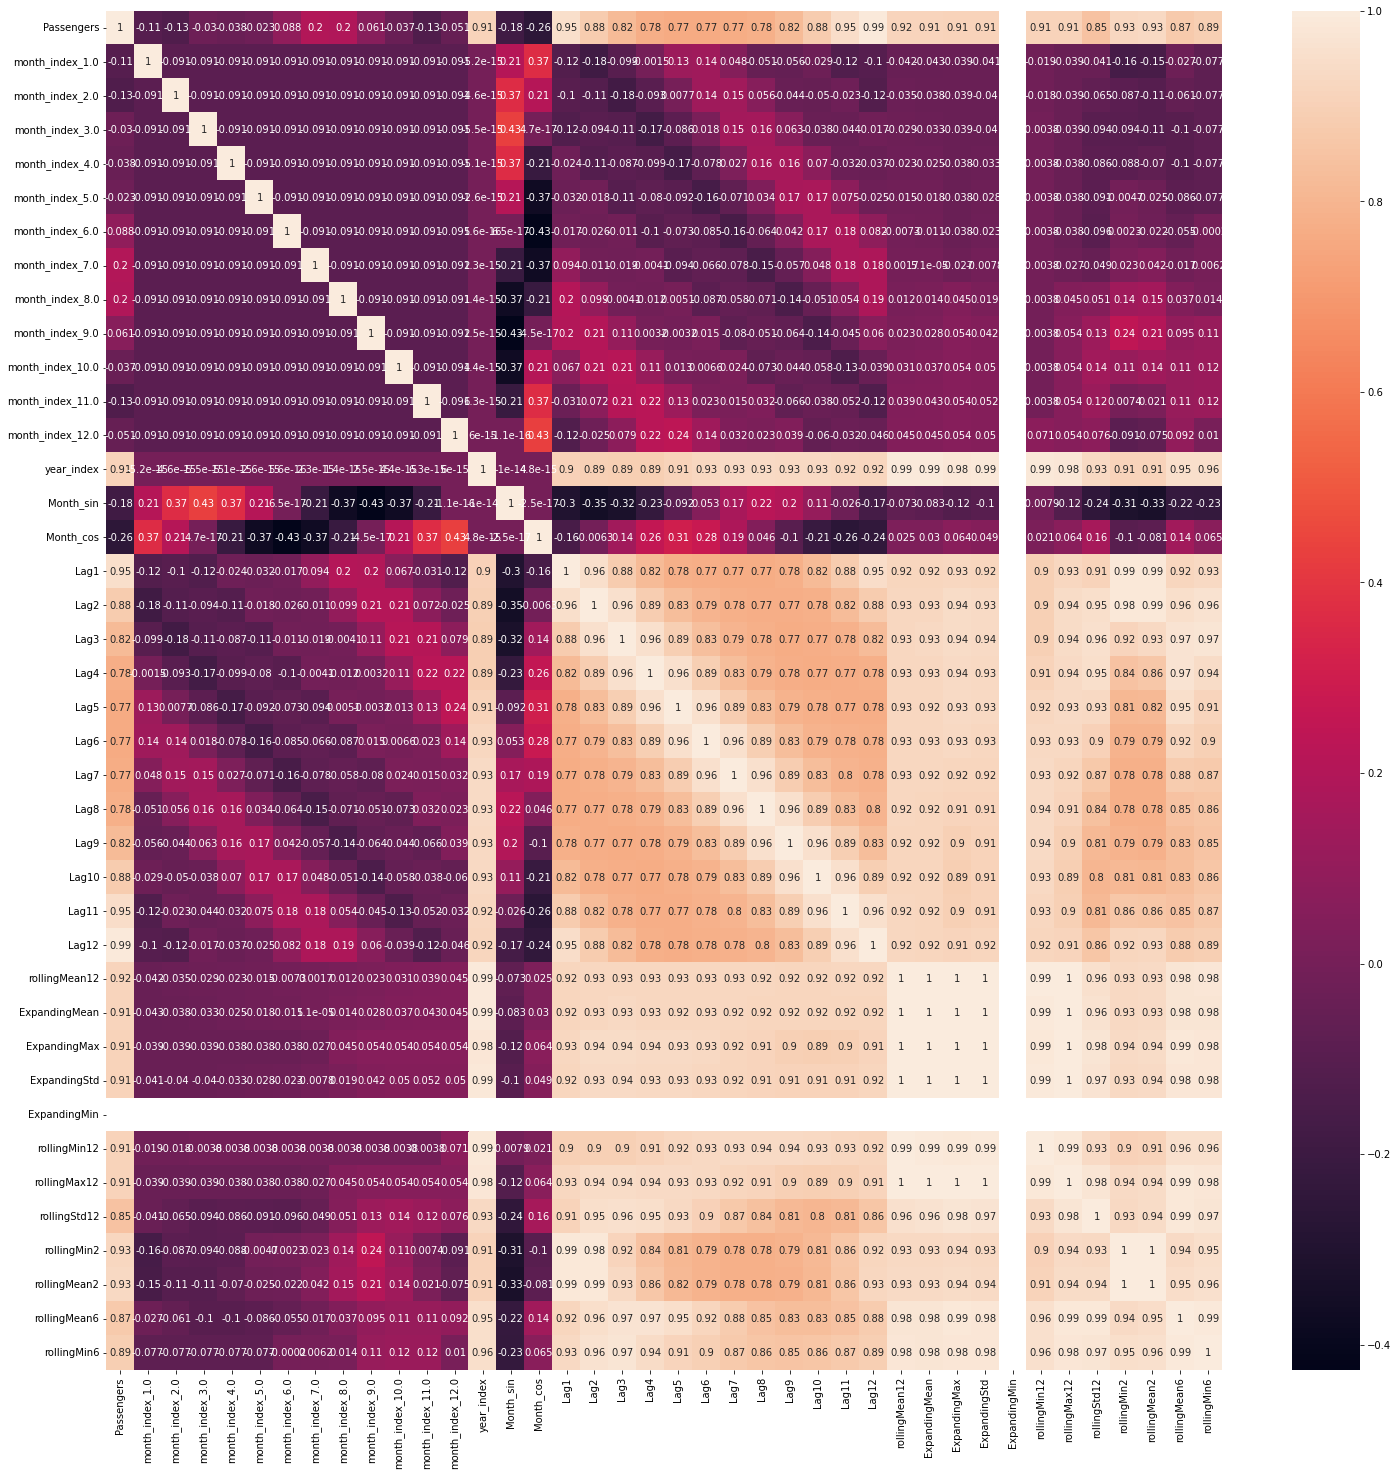

In [ ]:
corrMatrix = df.corr()
plt.figure(figsize=(25, 25))
sn.heatmap(corrMatrix, annot=True)
plt.show()

**Modelling**

1.   SVR
2.   Random_forest
3.   LightGBM
4.   LightGBM with sktime
5.   XGboost
6.   Auto Arima, Sarima, Sarimax
7.   LSTM

**Performance Metrics and Plots**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
# evaluateRegressor
def evaluateRegressor(true,predicted,message = "Test set"):
    mape = np.mean(np.abs(predicted - true)/np.abs(true))  # MAPE
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    LogRMSE = mean_squared_error(np.log(true),np.log(predicted),squared = False)
    r2 = r2_score(true, predicted)
    print(message)
    print("r2", r2)
    print("MAPE", mape)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)
    print("LogRMSE:", LogRMSE)

Splitting dataset into train and test set

In [ ]:
y =df["Passengers"]

In [ ]:
x= df.drop(["Passengers"], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.18, shuffle=False)

In [ ]:
X_test.shape

(24, 39)

In [ ]:
test_index = np.arange(120, 144, 1)

**SVR**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [ ]:
svr_df = DataFrame()
svr_df["Passengers"] = df["Passengers"]
svr_df["Lag1"] = df["Lag1"]
svr_df["Lag12"] = df["Lag12"]
svr_df['rollingMax12'] = df['rollingMax12']
svr_df["ExpandingMean"] = df["ExpandingMean"]
svr_df["rollingMean2"] = df["rollingMean2"]
svr_df["ExpandingStd"] = df['ExpandingStd']
svr_df['rollingMin12'] =df['rollingMin12']

In [ ]:
y= svr_df["Passengers"]
x= svr_df.drop(["Passengers"], axis=1)
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.18, shuffle=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
stds_X_train = StandardScaler()
stds_X_test = StandardScaler()
stds_y_train = StandardScaler()
stds_y_test = StandardScaler()

scaled_X_train = stds_X_train.fit_transform(X_train)
scaled_X_test = stds_X_test.fit_transform(X_test)
scaled_y_train = stds_y_train.fit_transform(y_train.to_numpy().reshape(-1,1))
scaled_y_test = stds_y_test.fit_transform(y_test.to_numpy().reshape(-1,1))

In [ ]:
svr_regressor = SVR(kernel='rbf')

grids = GridSearchCV( estimator=svr_regressor,
        param_grid={
            'degree' : [1,3],
            'C': [5.4, 150, 200, 300, 400],
            'epsilon': [0.0003, 0.007, 0.0109, 0.019, 0.14, 0.05, 8, 0.2, 3, 2, 7],
            'gamma': [0.008, 0.001, 0.01, 0.1, 1, 1.3, 5]
        },
        cv=5, verbose=0, n_jobs=-1)

grids.fit(scaled_X_train,scaled_y_train)


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [5.4, 150, 200, 300, 400], 'degree': [1, 3],
                         'epsilon': [0.0003, 0.007, 0.0109, 0.019, 0.14, 0.05,
                                     8, 0.2, 3, 2, 7],
                         'gamma': [0.008, 0.001, 0.01, 0.1, 1, 1.3, 5]})

In [ ]:
grids.best_params_

{'C': 5.4, 'degree': 1, 'epsilon': 0.05, 'gamma': 0.008}

Support Vector Machine
    Training Set
r2 0.9811225218399201
MAPE 0.041750413965550674
MSE: 153.99378390209128
MAE: 9.758727809134577
RMSE: 12.409423189741386
LogRMSE: 0.05419835206314692
    Test Set
r2 0.9623698014467257
MAPE 0.027999962681605678
MSE: 209.85185789456304
MAE: 12.3466606086527
RMSE: 14.486264456186179
LogRMSE: 0.03359822663301705


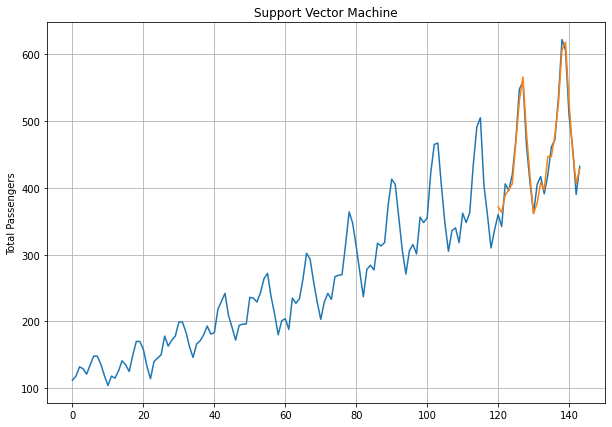

In [ ]:
print("Support Vector Machine") 
predicted_train_y = grids.predict(scaled_X_train)
predicted_train_y = stds_y_train.inverse_transform(predicted_train_y.reshape(-1,1))
evaluateRegressor(y_train.to_numpy().reshape(-1,1),predicted_train_y,"    Training Set")
SVR_prediction = grids.predict(scaled_X_test)
SVR_prediction = stds_y_test.inverse_transform(SVR_prediction.reshape(-1,1))
evaluateRegressor(y_test.to_numpy().reshape(-1,1),SVR_prediction,"    Test Set")
plt.figure(figsize=(10, 7))
plt.title('Support Vector Machine')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.plot(airline_data["Passengers"].values)
plt.plot(test_index, SVR_prediction)

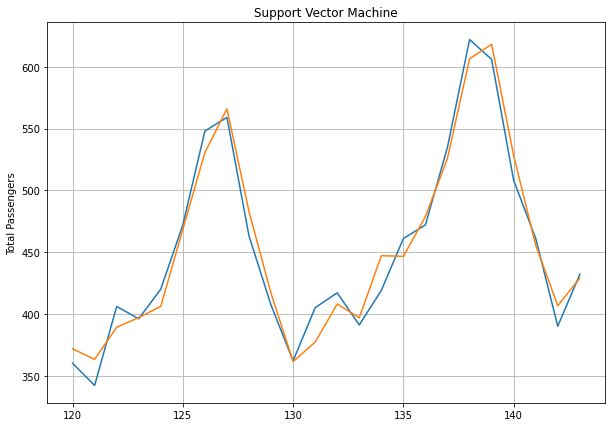

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Support Vector Machine')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.plot(test_index, airline_data["Passengers"].values[120:144])
plt.plot(test_index, SVR_prediction)

**Random Forest**

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from pandas import concat

In [ ]:
random_forest_df = DataFrame()
random_forest_df["Passengers"] = df["Passengers"]
random_forest_df["Lag1"] = df["Lag1"]
random_forest_df["Lag12"] = df["Lag12"]
random_forest_df["rollingMax12"] = df["rollingMax12"]
random_forest_df["ExpandingMean"] = df["ExpandingMean"]
random_forest_df["rollingMean2"] = df["rollingMean2"]
random_forest_df["ExpandingStd"] = df['ExpandingStd']
random_forest_df['rollingMin12'] =df['rollingMin12']

In [ ]:
y= random_forest_df["Passengers"]
x= random_forest_df.drop(["Passengers"], axis=1)
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.18, shuffle=False)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 300, num = 4)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 70, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 3, 4]
# Minimum number of samples required at each leaf node
min_samples_leaf = ["none",1, 2, 4]
# Create the random grid
grid_search_parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}

In [ ]:

grid_search_parameters

{'max_depth': [10, 40, 70, None],
 'max_features': ['auto'],
 'min_samples_leaf': ['none', 1, 2, 4],
 'min_samples_split': [1, 2, 3, 4],
 'n_estimators': [1, 100, 200, 300]}

In [ ]:
estimator = RandomForestRegressor(random_state = 0)
grid = GridSearchCV(estimator,grid_search_parameters, n_jobs=-1, cv=5)
grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [10, 40, 70, None],
                         'max_features': ['auto'],
                         'min_samples_leaf': ['none', 1, 2, 4],
                         'min_samples_split': [1, 2, 3, 4],
                         'n_estimators': [1, 100, 200, 300]})

In [ ]:
print(grid.best_score_ , grid.best_params_)


0.5485809968970106 {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}


In [ ]:
estimator.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

Random Forest Regressor
    Training Set
r2 0.9938754240736678
MAPE 0.02012079045787071
MSE: 49.96147333312878
MAE: 5.024558825690774
RMSE: 7.068343040142349
LogRMSE: 0.026848414869004505
    Test Set
r2 0.5651304875507299
MAPE 0.07229912709504972
MSE: 2425.1313742069383
MAE: 35.37653869047619
RMSE: 49.24562289388711
LogRMSE: 0.1000423326044605


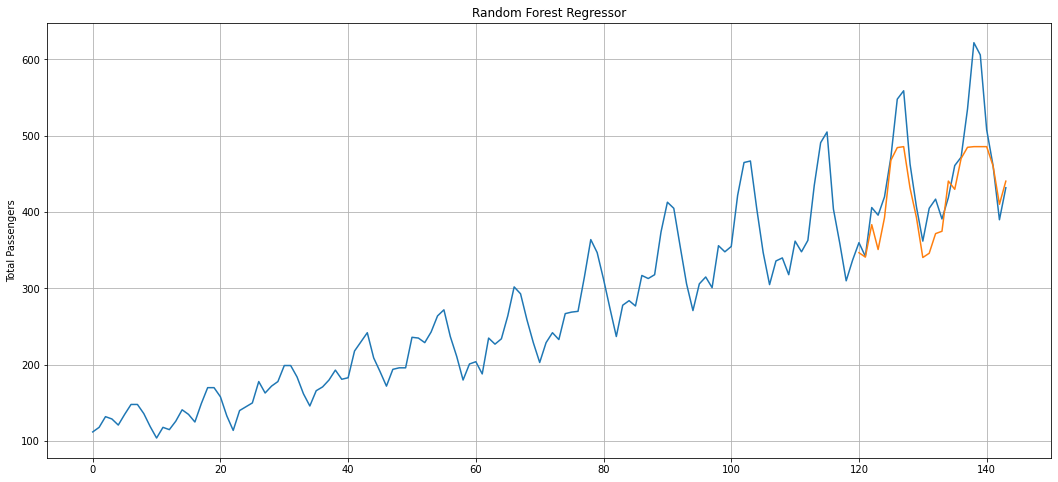

In [ ]:
##% Training and Evaluating Model
estimator = RandomForestRegressor(random_state = 0)
grid = GridSearchCV(estimator,grid_search_parameters, n_jobs=-1, cv=5)
grid.fit(X_train, y_train)
estimator.fit(X_train, y_train)
print("Random Forest Regressor") 
predicted_train_y = grid.predict(X_train)
evaluateRegressor(y_train,predicted_train_y,"    Training Set")
RF_prediction = grid.predict(X_test)
evaluateRegressor(y_test,RF_prediction,"    Test Set")
plt.title('Random Forest Regressor')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.plot( airline_data["Passengers"].values)
plt.plot(test_index, RF_prediction)

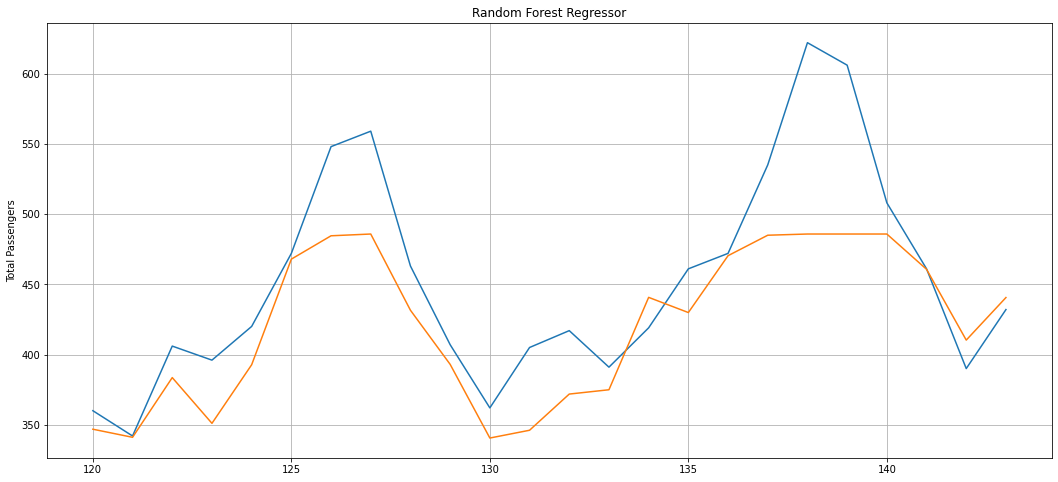

In [ ]:

plt.title('Random Forest Regressor')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.plot(test_index, airline_data["Passengers"].values[120:144])
plt.plot(test_index, RF_prediction)

In [ ]:
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

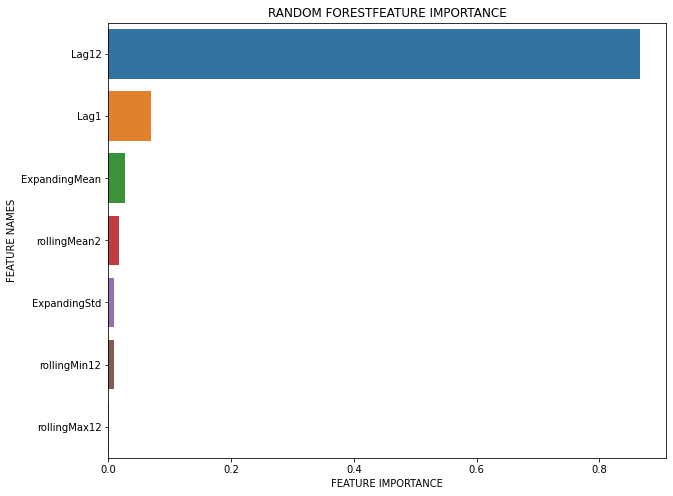

In [ ]:
plot_feature_importance(estimator.feature_importances_,x.keys(),'RANDOM FOREST')

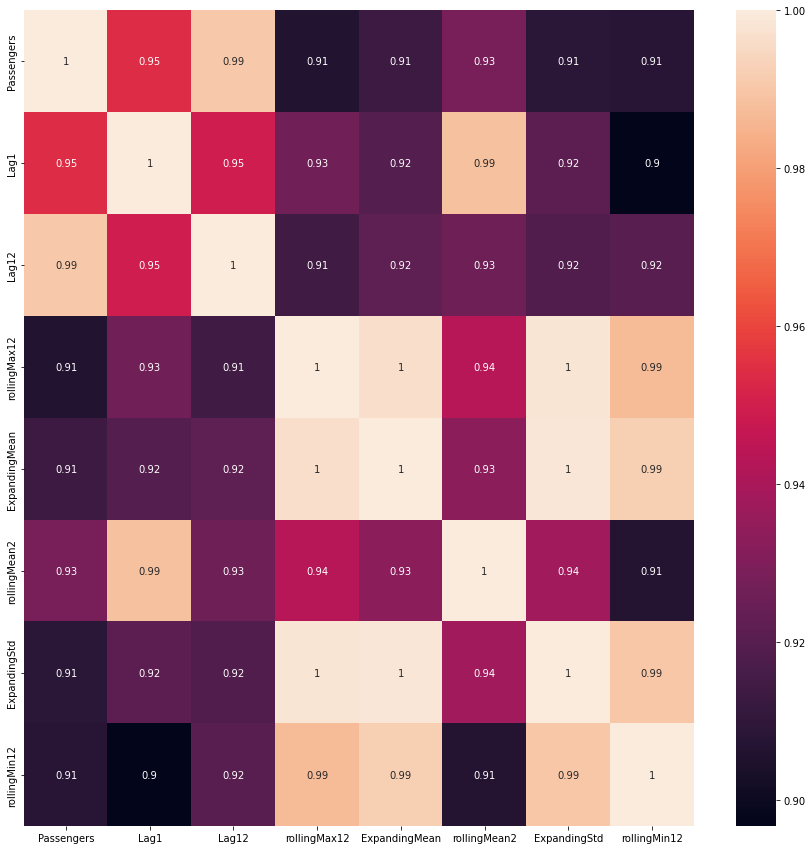

In [ ]:
import seaborn as sn

corrMatrix = random_forest_df.corr()
plt.figure(figsize=(15, 15))
sn.heatmap(corrMatrix, annot=True)
plt.show()

**LightGBM without Sktime**

In [ ]:
AZimport lightgbm as lgb
from lightgbm import LGBMRegressor 

In [ ]:
lightgbm_df = DataFrame()
lightgbm_df["Passengers"] = df["Passengers"]
lightgbm_df["Lag1"] = df["Lag1"]
lightgbm_df["Lag12"] = df["Lag12"]
lightgbm_df["rollingMax12"] = df["rollingMax12"]
lightgbm_df["ExpandingMean"] = df["ExpandingMean"]
lightgbm_df["rollingMean2"] = df["rollingMean2"]
lightgbm_df["ExpandingStd"] = df['ExpandingStd']
lightgbm_df['rollingMin12'] =df['rollingMin12']

In [ ]:
y= lightgbm_df["Passengers"]
x= lightgbm_df.drop(["Passengers"], axis=1)
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.18, shuffle=False)

In [ ]:
# grid search parameter tuning

parameters = {
    'task' : ['predict'],
     'boosting': ['gbdt' ],
     'objective': ['root_mean_squared_error'],
     'num_iterations': [200, 300, 350],
     'learning_rate':[ 0.001, 0.05, 0.1 ],
    'num_leaves':[ 1, 3, 7  ],
    'max_depth' :[ 1, 3, 5],
    'min_data_in_leaf':[1, 3 ,5 ],
   'feature_fraction': [ 0.8],
     'bagging_fraction': [  0.8 ],
     'bagging_freq': [ 50, 60],}

lgb_model = lgb.LGBMRegressor(random_state=0)
gsearch_lgb = GridSearchCV(lgb_model, param_grid = parameters, n_jobs=6, verbose=10)
gsearch_lgb.fit(X_train,y_train)
 

print('best params')
print (gsearch_lgb.best_params_)
preds_lgb_model = gsearch_lgb.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, preds_lgb_model))
print(" RMSE: %f" % (rmse_lgb ))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
best params
{'bagging_fraction': 0.8, 'bagging_freq': 60, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_data_in_leaf': 3, 'num_iterations': 200, 'num_leaves': 3, 'objective': 'root_mean_squared_error', 'task': 'predict'}
 RMSE: 55.926375


In [ ]:
lgb_model = lgb.LGBMRegressor(random_state=0).fit(X_train, y_train)

LightGBM Regressor
    Training Set
r2 0.9881487555074471
MAPE 0.03066728899915873
MSE: 96.67700144484327
MAE: 7.455007622565392
RMSE: 9.832446361147529
LogRMSE: 0.039530982090664704
    Test Set
r2 0.43913668889139834
MAPE 0.08311080589979226
MSE: 3127.75941626795
MAE: 40.84640275034226
RMSE: 55.92637496090686
LogRMSE: 0.11438867164181858


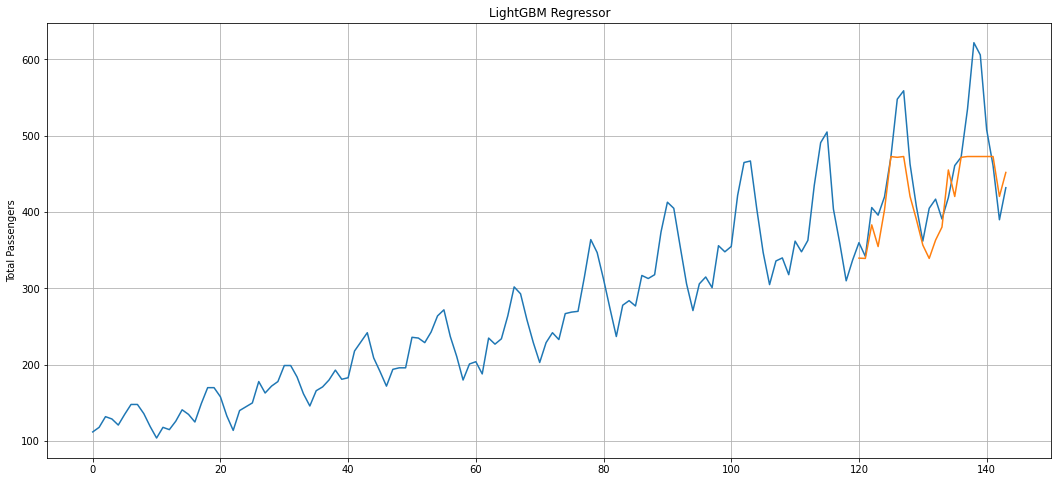

In [ ]:

lgb_model = lgb.LGBMRegressor(random_state=0).fit(X_train, y_train)
print("LightGBM Regressor") 
predicted_train_y = gsearch_lgb.predict(X_train)
evaluateRegressor(y_train,predicted_train_y,"    Training Set")
LGB_prediction = gsearch_lgb.predict(X_test)
evaluateRegressor(y_test,LGB_prediction,"    Test Set")
plt.title('LightGBM Regressor')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.plot(airline_data["Passengers"].values)
plt.plot(test_index, LGB_prediction)

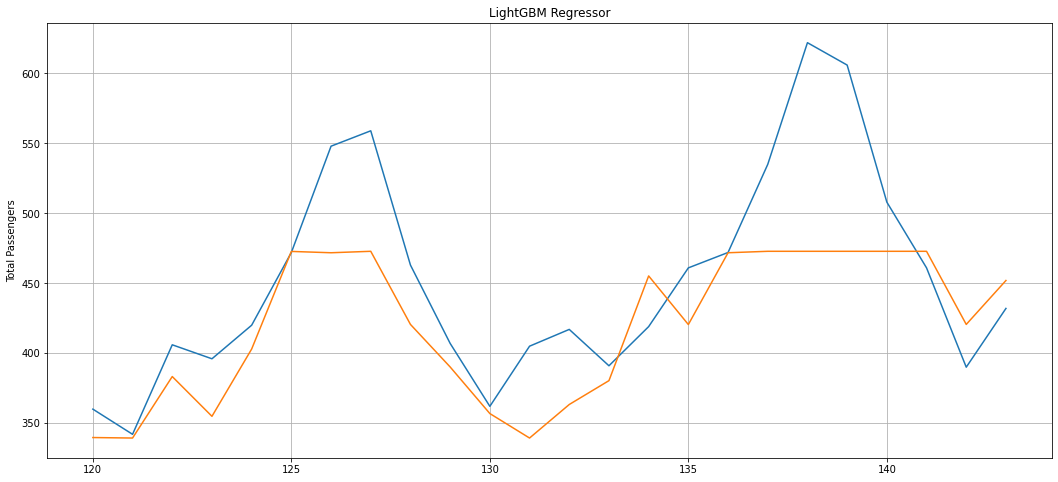

In [ ]:
plt.title('LightGBM Regressor')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.plot(test_index, airline_data["Passengers"].values[120:144])
plt.plot(test_index, LGB_prediction)

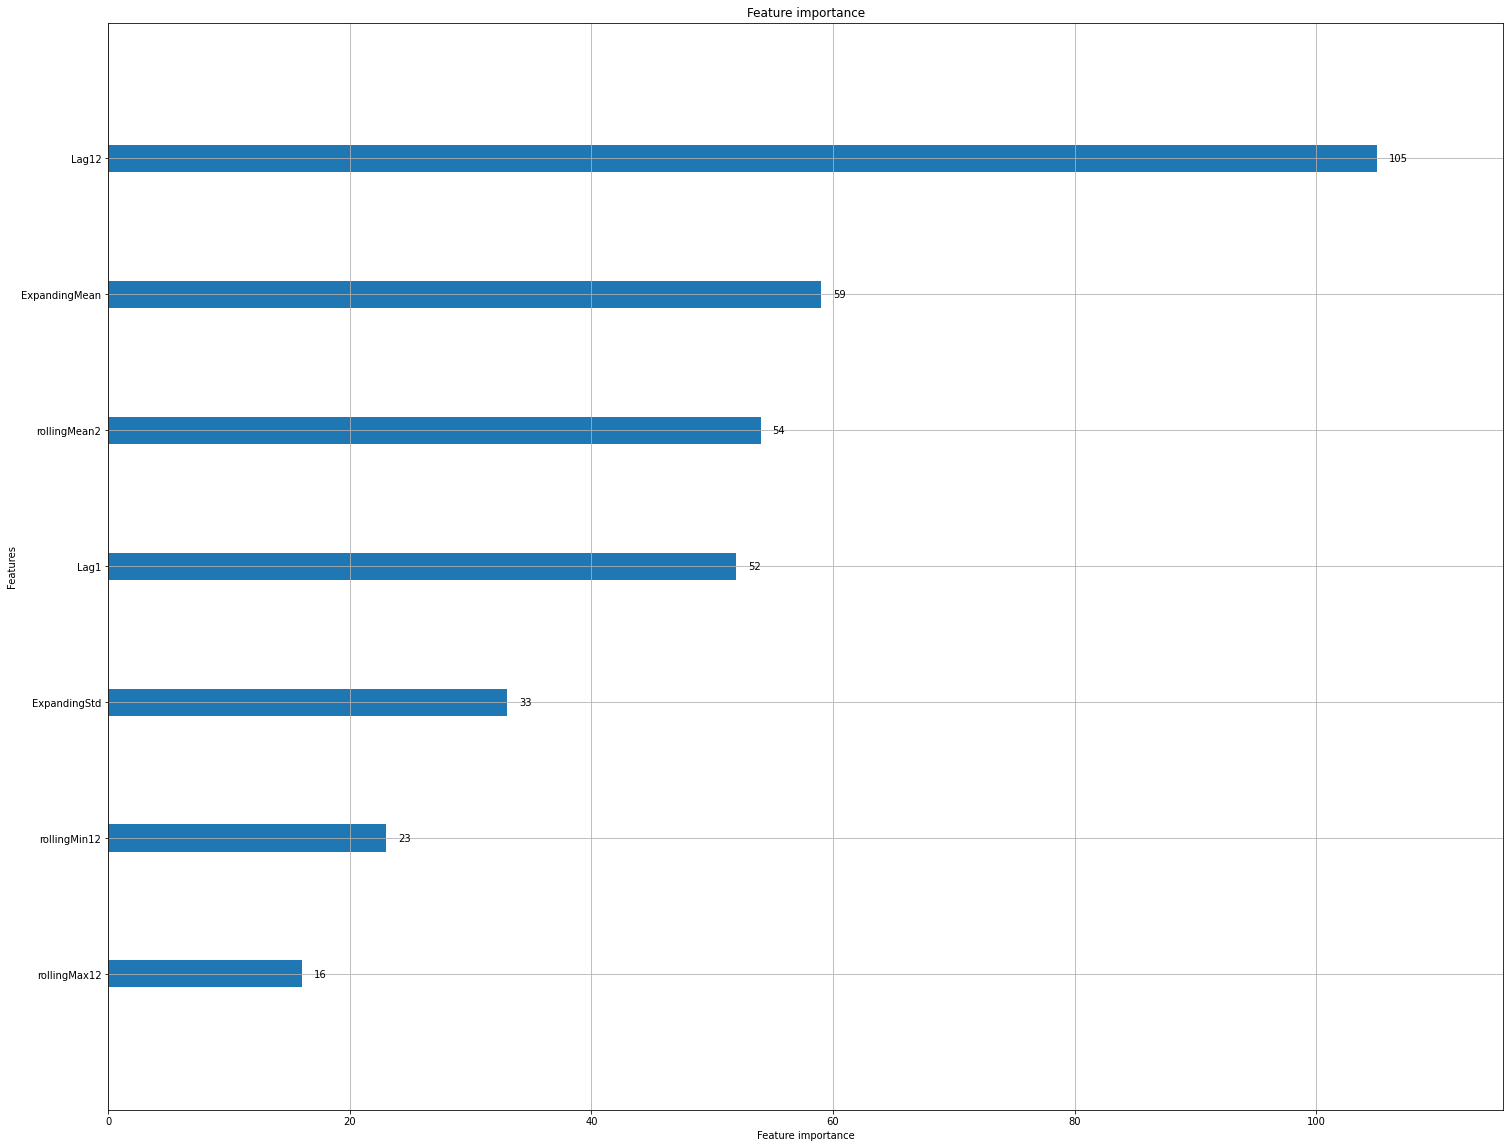

In [ ]:
##% Feature Importance 
lgb.plot_importance(lgb_model,figsize=(25,20))

**LightGBM with Sktime**

In [ ]:
pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.compose import TransformedTargetForecaster
import statsmodels as sm

In [ ]:
lightgbm_sktime_df= airline_data["Passengers"]

In [ ]:
def tsplot(y, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    plot_acf(y, ax= acf_ax, lags = 30)
    plot_pacf(y, ax=pacf_ax, lags = 30)
    plt.tight_layout()


In [ ]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)
    rmse = mean_squared_error(series_test,forecast,squared = False)
    r2 = r2_score(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}, RMSE: {rmse:.3f}, r2: {r2:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape,rmse, r2

In [ ]:
def create_forecaster():
    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=6, strategy="recursive")
    
    return forecaster

def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")
    
    # forecasting
    fh=np.arange(len(test))+1
    y_pred = gscv.predict(fh=fh)
    mae, mape, rmse, r2 = plot_forecast(train, test, y_pred)

    return mae, mape, rmse, r2

In [ ]:
al_train, al_test = lightgbm_sktime_df.iloc[:-24], lightgbm_sktime_df.iloc[-24:]

best params: {'forecast__window_length': 6}


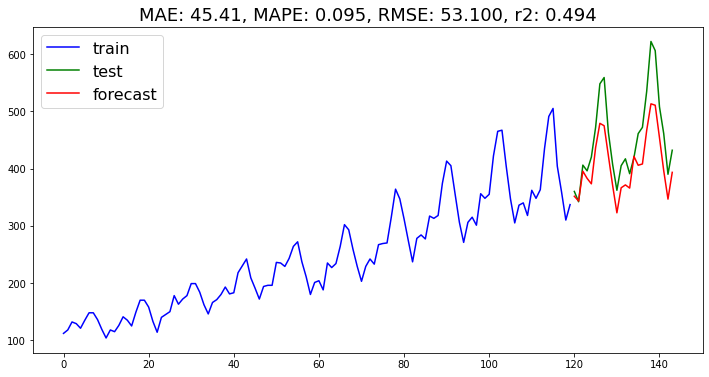

In [ ]:
from sktime.transformations.series.detrend import Deseasonalizer

def create_forecaster_w_desesonalizer(sp=12, degree=1):

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="multiplicative", sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=6, strategy="recursive"),
            ),
        ]
    )

    return forecaster
    
forecaster = create_forecaster_w_desesonalizer()
param_grid = {"forecast__window_length": [6, 12, 18, 24, 30, 36]}
al_lgb_mae, al_lgb_mape, al_lgb_rmse, al_lgb_r2 = grid_serch_forecaster(al_train, al_test, forecaster, param_grid)

**XGBOOST**

In [ ]:
xgboost_df = DataFrame()
xgboost_df["Passengers"] = df["Passengers"]
xgboost_df["Lag1"] = df["Lag1"]
xgboost_df["Lag12"] = df["Lag12"]
xgboost_df["rollingMax12"] = df["rollingMax12"]
xgboost_df["ExpandingMean"] = df["ExpandingMean"]
xgboost_df["rollingMean2"] = df["rollingMean2"]
xgboost_df["ExpandingStd"] = df['ExpandingStd']
xgboost_df["rollingMin12"] = df["rollingMin12"]

In [ ]:
y= xgboost_df["Passengers"]
x= xgboost_df.drop(["Passengers"], axis=1)
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.18, shuffle=False)

In [ ]:
import xgboost as xg
XGReg = xg.XGBRegressor(objective ="reg:squarederror", seed = 0,verbosity=0).fit(X_train, y_train) 

In [ ]:
param_grid = {
    'n_estimators': [1, 50, 100, 150],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
}

gsearch_xg = GridSearchCV(XGReg, param_grid = param_grid, n_jobs=6, verbose=10)
gsearch_xg.fit(X_train,y_train)
 


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', seed=0,
                                    verbosity=0),
             n_jobs=6,
             param_grid={'colsample_bytree': [0.7, 0.8],
                         'max_depth': [15, 20, 25],
                         'n_estimators': [1, 50, 100, 150],
                         'reg_alpha': [1.1, 1.2, 1.3],
                         'reg_lambda': [1.1, 1.2, 1.3],
                         'subsample': [0.7, 0.8, 0.9]},
             verbose=10)

In [ ]:
print(gsearch_xg.best_score_ , gsearch_xg.best_params_)

0.5679242263026157 {'colsample_bytree': 0.8, 'max_depth': 15, 'n_estimators': 150, 'reg_alpha': 1.1, 'reg_lambda': 1.3, 'subsample': 0.7}


XGBoost Regressor
    Training Set
r2 0.9999195174937694
MAPE 0.0019296424457954703
MSE: 0.6565392669123227
MAE: 0.4900846834535952
RMSE: 0.8102711070452424
LogRMSE: 0.002945325972304177
    Test Set
r2 0.30403124724008357
MAPE 0.1017746148851214
MSE: 3881.2002439068165
MAE: 49.15909067789713
RMSE: 62.29927964195747
LogRMSE: 0.13071066094308664


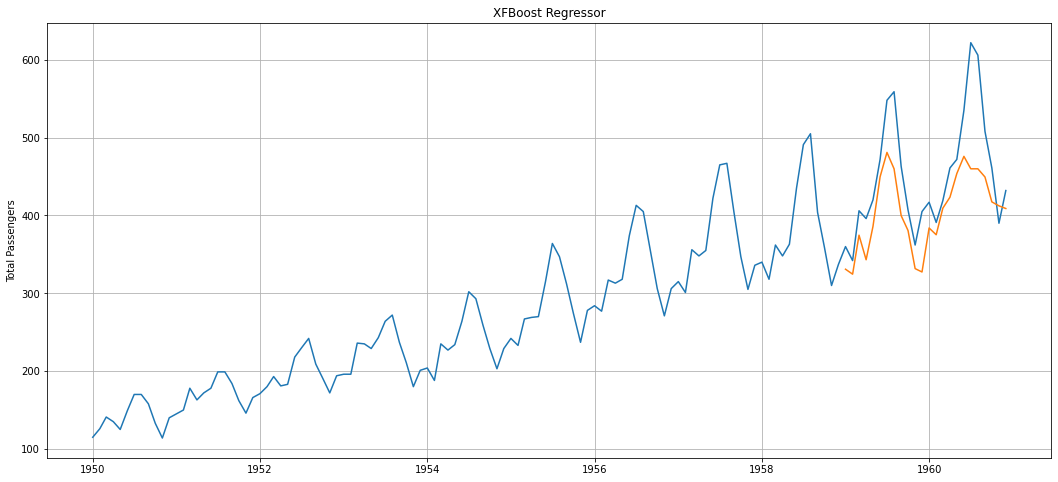

In [ ]:
print("XGBoost Regressor") 
predicted_train_y = gsearch_xg.predict(X_train)
evaluateRegressor(y_train,predicted_train_y,"    Training Set")
Xgboost_prediction = gsearch_xg.predict(X_test)
evaluateRegressor(y_test,Xgboost_prediction,"    Test Set")
plt.title('XFBoost Regressor')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.plot(xgboost_df.index,xgboost_df["Passengers"])
plt.plot(X_test.index, Xgboost_prediction)

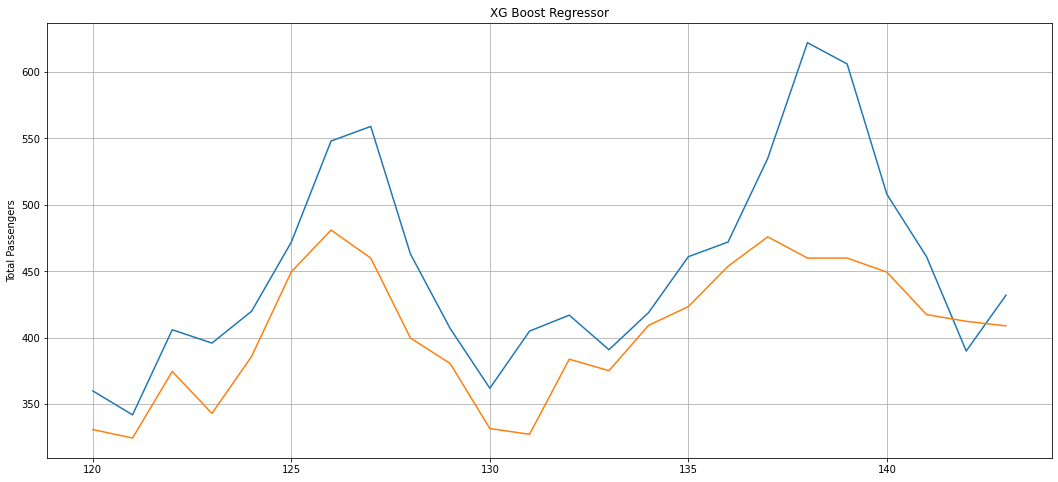

In [ ]:
plt.title('XG Boost Regressor')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.plot(test_index, airline_data["Passengers"].values[120:144])
plt.plot(test_index, Xgboost_prediction)

**ARIMA, SARIMA, SARIMAX**

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
arima_df = pd.read_csv("/content/drive/MyDrive/Airline.csv")

In [ ]:
#string to date format
arima_df['Date'] = pd.to_datetime(arima_df['Date'],infer_datetime_format=True)
arima_df = arima_df.set_index(['Date'])

In [ ]:
train, test = arima_df.iloc[:-24], arima_df.iloc[-24:]

In [ ]:
train

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1958-08-01,505
1958-09-01,404
1958-10-01,359


In [ ]:
forecaster = model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=15, max_q=15,
                      m=12,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
forecaster.fit(train)
forecaster.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1126.948, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1140.292, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1132.336, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1128.668, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1138.809, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1128.350, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1128.337, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1087.029, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -537.515
Date:                Fri, 12 Aug 2022   AIC                           1087.029
Time:                        06:20:19   BIC                           1103.704
Sample:                             0   HQIC                          1093.800
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5732      0.189      3.038      0.002       0.203       0.943
ar.L1          1.6431      0.029     57.063      0.000       1.587       1.700
ar.L2         -0.9066      0.028    -32.232      0.000      -0.962      -0.851
ma.L1         -1.8747      0.035    -53.467      0.000      -1.943      -1.806
ma.L2          0.9691      0.036     27.230      0.000       0.899       1.039
sigma2       467.5752     66.672      7.013      0.000     336.900     598.250
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.37   Prob(JB):                         0.97
Heteroskedasticity (H):               5.74   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast, forecast_int = forecaster.predict(24, return_conf_int=True)

In [ ]:
cf= pd.DataFrame(forecast_int)
cf2= pd.DataFrame(forecast)


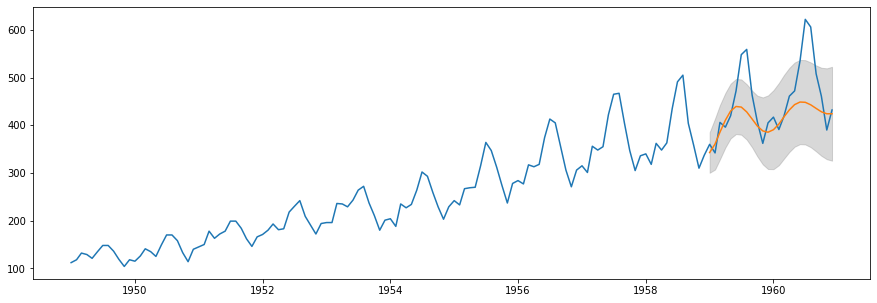

In [ ]:
prediction_series = pd.Series(forecast,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(arima_df)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [ ]:
prediction_series = prediction_series.to_frame()


In [ ]:
prediction_series["Passengers"]= prediction_series[0]
prediction_series = prediction_series.drop([0], axis=1)

In [ ]:
print("ARIMA") 
evaluateRegressor(test,prediction_series,"    Test Set")

ARIMA
    Test Set
r2 0.1805243479265216
MAPE Passengers    0.09234
dtype: float64
MSE: 4569.959625472516
MAE: 46.92653724062804
RMSE: 67.6014765036424
LogRMSE: 0.13598117474414523


In [ ]:
prediction_series

,Passengers
Date,
1959-01-01,342.787406
1959-02-01,360.724626
1959-03-01,385.524263
1959-04-01,410.584737
1959-05-01,429.852319
1959-06-01,439.364922
1959-07-01,438.100623
1959-08-01,427.972300
1959-09-01,413.049547


**SARIMA**

In [ ]:
sarima_df = pd.read_csv("/content/drive/MyDrive/Airline.csv")

In [ ]:
#string to date format
sarima_df['Date'] = pd.to_datetime(sarima_df['Date'],infer_datetime_format=True)
sarima_df = sarima_df.set_index(['Date'])

In [ ]:
train, test = indexed_data["Passengers"].iloc[:-24], indexed_data["Passengers"].iloc[-24:]

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
SARIMA_model.fit(train)
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -399.641
Date:                            Fri, 12 Aug 2022   AIC                            803.281
Time:                                    06:20:37   BIC                            808.627
Sample:                                         0   HQIC                           805.448
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2397      0.091     -2.629      0.009      -0.418      -0.061
sigma2       102.6681     12.363      8.304      0.000      78.437     126.899
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.93   Prob(JB):                         0.38
Heteroskedasticity (H):               1.42   Skew:                             0.02
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast, forecast_int = SARIMA_model.predict(24, return_conf_int=True)
cf= pd.DataFrame(forecast_int)

In [ ]:
sarima_df[132:144].index

DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

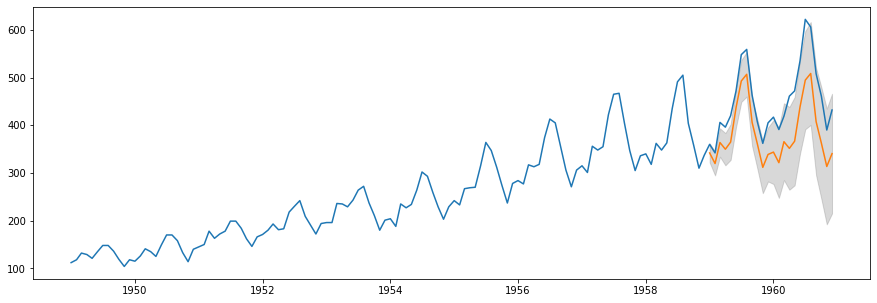

In [ ]:
prediction_series = pd.Series(forecast,index=arima_df[120:144].index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(arima_df)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [ ]:
print("SARIMA") 
evaluateRegressor(test,prediction_series,"    Test Set")

SARIMA
    Test Set
r2 0.011349985876093371
MAPE 0.14927552691246468
MSE: 5513.392175639613
MAE: 68.57726547031133
RMSE: 74.25222000478917
LogRMSE: 0.174704644378657


**SARIMAX**

In [ ]:
sarimax_df = DataFrame()
sarimax_df["Passengers"] = df["Passengers"]
sarimax_df["Lag1"] = df["Lag1"]
sarimax_df["ExpandingMin"] = df["ExpandingMin"]
sarimax_df["ExpandingMean"] = df["ExpandingMean"]
sarimax_df["rollingMean2"] = df["rollingMean2"]
sarimax_df["ExpandingStd"] = df['ExpandingStd']

In [ ]:
train, test = sarimax_df.iloc[:-24], sarimax_df.iloc[-24:]

In [ ]:
exogenous_features=["rollingMean2","ExpandingMean","ExpandingMin","ExpandingStd","Lag1"]

In [ ]:
# SARIMAX Model
SARIMAX_model = pm.auto_arima(train[["Passengers"]], exogenous=train[exogenous_features],
                         start_p=1, start_q=1,
                         test='adf',
                         max_p=24, max_q=24, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
SARIMAX_model.fit(train[["Passengers"]],exogenous= train[exogenous_features])
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  108
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -358.424
Date:                  Fri, 12 Aug 2022   AIC                            728.848
Time:                          06:20:46   BIC                            744.235
Sample:                      01-01-1950   HQIC                           735.068
                           - 12-01-1958                                         
Covariance Type:                    opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
rollingMean2      0.4153      0.229      1.816      0.069      -0.033       0.863
ExpandingMean     1.1611      0.621      1.871      0.061      -0.055       2.377
ExpandingMin   3.383e-11        nan        nan        nan         nan         nan
ExpandingStd     -1.3721      0.948     -1.447      0.148      -3.230       0.486
Lag1              0.4756      0.210      2.268      0.023       0.065       0.887
sigma2          102.4417     13.578      7.545      0.000      75.830     129.054
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.46
Prob(Q):                              0.93   Prob(JB):                         0.48
Heteroskedasticity (H):               1.06   Skew:                            -0.09
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.97e+20. Standard errors may be unstable.
"""

In [ ]:
forecast, forecast_int = SARIMAX_model.predict(24, return_conf_int=True, exogenous= test[exogenous_features])
cf= pd.DataFrame(forecast_int)

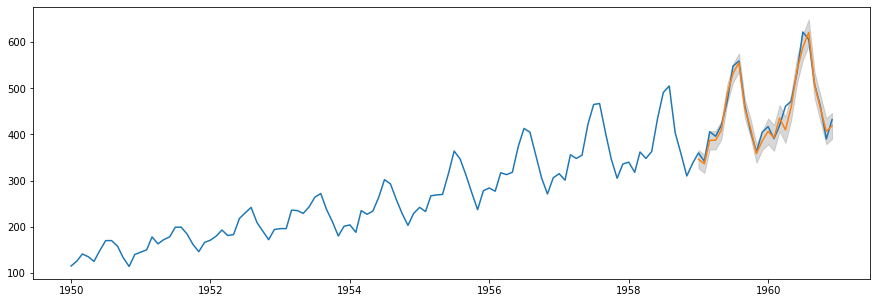

In [ ]:
Sarimax_prediction = pd.Series(forecast,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(df["Passengers"])
ax.plot(Sarimax_prediction)
ax.fill_between(Sarimax_prediction.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

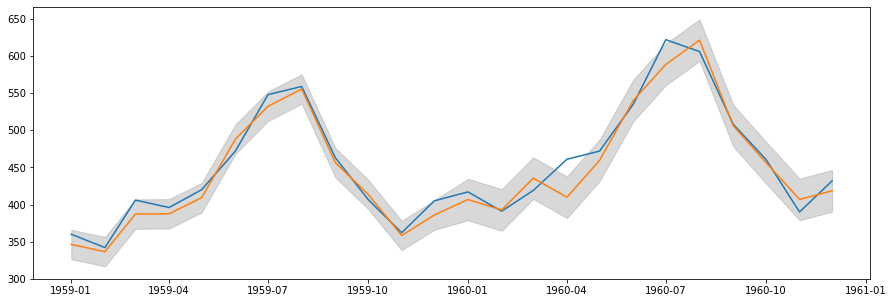

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(Sarimax_prediction.index,df["Passengers"][108:132])
ax.plot(Sarimax_prediction)
ax.fill_between(Sarimax_prediction.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [ ]:
print("SARIMAX") 
evaluateRegressor(test["Passengers"],Sarimax_prediction,"    Test Set")

SARIMAX
    Test Set
r2 0.9495022666460807
MAPE 0.028596236221404208
MSE: 281.6100783731345
MAE: 12.958059544430078
RMSE: 16.78124186027764
LogRMSE: 0.03732712092847102


**LSTM**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [ ]:
lstm_model= pd.read_csv("/content/drive/MyDrive/Airline.csv")

In [ ]:
lstm_data = lstm_model.iloc[:,1:2].values

In [ ]:
# Take Date feature as datetime index for simplicity
lstm_model['Date'] = pd.to_datetime(lstm_model['Date'], infer_datetime_format=True)
lstm_model = lstm_model.set_index(['Date']) # 144 rows  x 1 columns

In [ ]:
lstm_data.shape

(144, 1)

In [ ]:
def sliding_window(data, seq_length):
    x = []
    y = []

    for i in range(144-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
       

    return np.array(x),np.array(y)

sc = MinMaxScaler()
lstm_data = sc.fit_transform(lstm_data)

seq_length = 12
inout_seq=[]
features, passengers = sliding_window(lstm_data, seq_length)

train_size = 120
test_size = 24

dataX = Variable(torch.Tensor(np.array(features)))
dataY = Variable(torch.Tensor(np.array(passengers)))

trainX = Variable(torch.Tensor(np.array(features[0:108])))
trainY = Variable(torch.Tensor(np.array(passengers[0:108])))
inout_seq.append((trainX ,trainY))

testX = Variable(torch.Tensor(np.array(features[108:132])))
testY = Variable(torch.Tensor(np.array(passengers[108:132])))

In [ ]:

print(testY.shape)
print(trainX.shape)

torch.Size([24, 1])
torch.Size([108, 12, 1])


In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
num_epochs = 2000
learning_rate = 0.001

input_size = 1
hidden_size = 32
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

for i in range(num_epochs):
    for seq, labels in inout_seq:
        optimizer.zero_grad()
        lstm.hidden_cell = (torch.zeros(1, 1, 10),
                        torch.zeros(1, 1, 10))

        y_pred = lstm(seq)

        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%100 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.08945525
epoch: 100 loss: 0.00783608
epoch: 200 loss: 0.00532831
epoch: 300 loss: 0.00476915
epoch: 400 loss: 0.00371835
epoch: 500 loss: 0.00130241
epoch: 600 loss: 0.00105763
epoch: 700 loss: 0.00094245
epoch: 800 loss: 0.00088859
epoch: 900 loss: 0.00082705
epoch: 1000 loss: 0.00085543
epoch: 1100 loss: 0.00075064
epoch: 1200 loss: 0.00104723
epoch: 1300 loss: 0.00069850
epoch: 1400 loss: 0.00068802
epoch: 1500 loss: 0.00065338
epoch: 1600 loss: 0.00063614
epoch: 1700 loss: 0.00062099
epoch: 1800 loss: 0.00060259
epoch: 1900 loss: 0.00060670
epoch: 1999 loss: 0.0005740136


Text(0.5, 0.98, 'Time-Series Prediction')

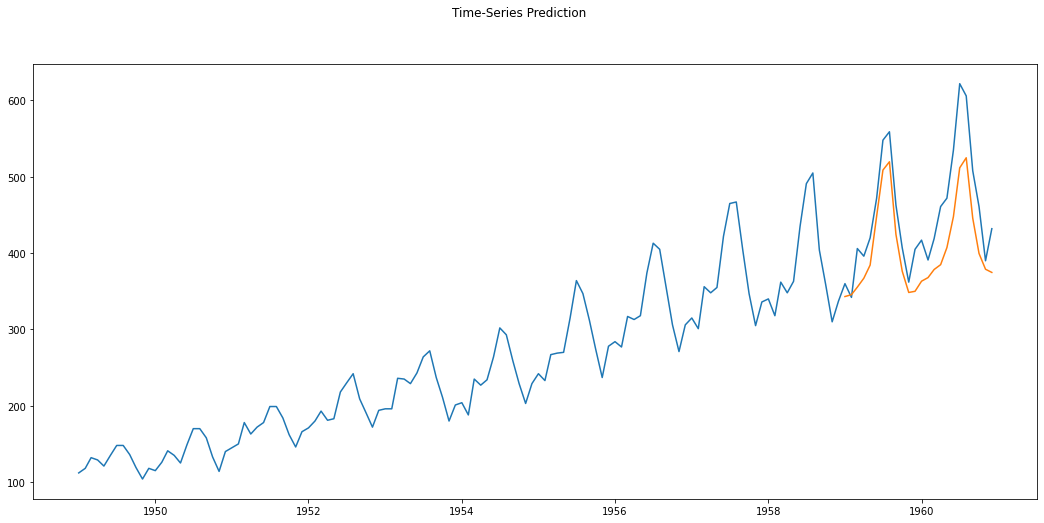

In [ ]:
lstm.eval()
train_predict = lstm(testX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

LSTM_prediction = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.plot(lstm_model.index,lstm_model)
plt.plot(y_test.index, LSTM_prediction)
plt.suptitle('Time-Series Prediction')

In [ ]:
print("LSTM") 
evaluateRegressor(lstm_model["Passengers"][120:144].to_numpy(),LSTM_prediction,"    Test Set")

LSTM
    Test Set
r2 0.5019939608155244
MAPE 0.17288787820574114
MSE: 2777.224053644575
MAE: 46.005897521972656
RMSE: 52.69937431928936
LogRMSE: 0.11546205955731137


**All Models**

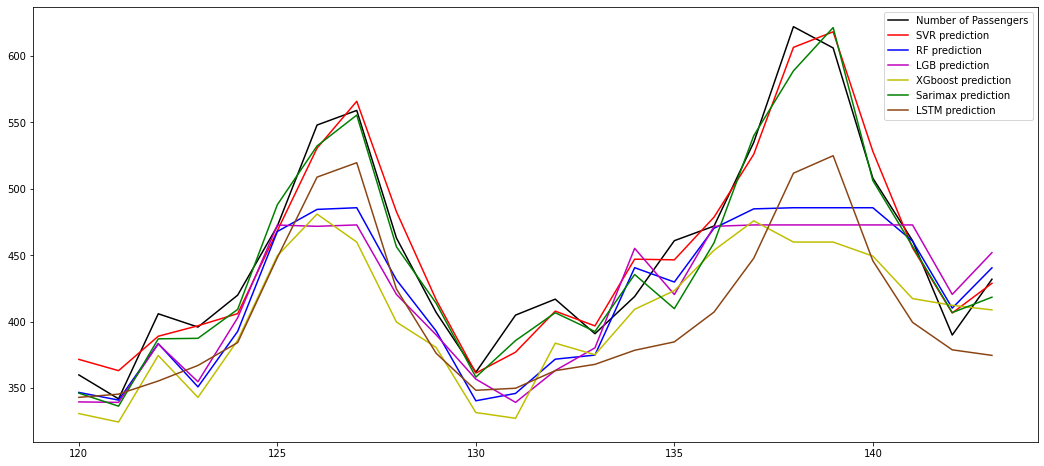

In [ ]:

# Original Data
plt.plot(test_index,airline_data["Passengers"].values[120:144], color='k', label='Number of Passengers')

# SVR Prediction
plt.plot(test_index, SVR_prediction, color='r', label='SVR prediction')

# Random Forest Prediction
plt.plot(test_index, RF_prediction, color='b', label='RF prediction')

# LightGBM Prediction
plt.plot(test_index, LGB_prediction, color='m', label='LGB prediction')

# Xgboost Prediction
plt.plot(test_index, Xgboost_prediction, color='y', label='XGboost prediction')

# Sarimax Prediction
plt.plot(test_index, Sarimax_prediction, color='g', label='Sarimax prediction')

# Lstm Prediction
plt.plot(test_index, LSTM_prediction, color='saddlebrown', label='LSTM prediction')

plt.legend()
plt.show()

**Performance Metrics for All Models**

In [ ]:
from prettytable import PrettyTable
 
# Specify the Column Names while initializing the Table
model_table = PrettyTable(["Model Name","MAPE", "RMSE", "R2"])

# Add rows
model_table.add_row(["SVR", " 0.0279 ", "14.486", "0.962" ])
model_table.add_row(["RF", "0.0714", "47.076", "0.602"])
model_table.add_row(["LGBM ", "0.0857", "58.125", "0.394"])
model_table.add_row(["LGBM (sktime)", "0.095", "53.100", "0.494"])
model_table.add_row(["XGboost", "0.0912", "59.776", "0.359"])
model_table.add_row(["Sarimax", "0.0286", "16.781", "0.950"])
model_table.add_row(["LSTM", "0.1810", "38.832", "0.730"])
print(model_table)

+---------------+----------+--------+-------+
|   Model Name  |   MAPE   |  RMSE  |   R2  |
+---------------+----------+--------+-------+
|      SVR      |  0.0398  | 23.066 | 0.904 |
|       RF      |  0.0714  | 47.076 | 0.602 |
|     LGBM      |  0.0857  | 58.125 | 0.394 |
| LGBM (sktime) |  0.095   | 53.100 | 0.494 |
|    XGboost    |  0.0912  | 59.776 | 0.359 |
|    Sarimax    |  0.0286  | 16.781 | 0.950 |
|      LSTM     |  0.1810  | 38.832 | 0.730 |
+---------------+----------+--------+-------+
